# Title: Analysis of effect of market sentiment on trade behaviour and performance

# Author: Souhardya Das

## PART-A : Data preparation

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split


### Loading data

In [176]:
df1= pd.read_csv('C:\\Users\\Souhar\\OneDrive\\Desktop\\Career\\Tasks\\PrimeTrade\\fear_greed_index.csv')
df2= pd.read_csv('C:\\Users\\Souhar\\OneDrive\\Desktop\\Career\\Tasks\\PrimeTrade\\historical_data.csv')

In [177]:
df1.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [178]:
df2.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


### Basic checks

In [179]:
print("Fear & Greed shape:", df1.shape)
print("Trader data shape:", df2.shape)

print("\nFear & Greed dtypes:")
print(df1.dtypes)

print("\nTrader data dtypes:")
print(df2.dtypes)


Fear & Greed shape: (2644, 4)
Trader data shape: (211224, 16)

Fear & Greed dtypes:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Trader data dtypes:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object


### Missing values and duplicates check

In [180]:
print("df1 missing values:")
print(df1.isna().sum())
print("df2 missing values:")
print(df2.isna().sum())


df1 missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64
df2 missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


No missing values in data to drop

In [181]:
df1_exact_duplicates = df1.duplicated().sum()
print("df1 –> exact duplicate rows:", df1_exact_duplicates)

df2_exact_duplicates = df2.duplicated().sum()
print("df2 –> exact duplicate rows:", df2_exact_duplicates)

df1 –> exact duplicate rows: 0
df2 –> exact duplicate rows: 0


No duplicates in data

### Extracting date columns from both data


In [182]:
df1["date"] = pd.to_datetime(df1["date"]).dt.date

In [183]:
df2["date"] = pd.to_datetime(df2["Timestamp"], unit="ms", utc=True).dt.date

In [184]:
df2["datetime"] = pd.to_datetime(
    df2["Timestamp IST"],
    format="%d-%m-%Y %H:%M"
)
df2["date"] = df2["datetime"].dt.date
df2.drop(columns=["datetime"], inplace=True)

### Merging dataframes to match sentiment with trader and date data

In [185]:
df2 = df2.merge(
    df1[["date", "classification", "value"]],
    on="date",
    how="left"
)


In [186]:
df2["classification"].value_counts(dropna=False)


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
NaN                  6
Name: count, dtype: int64

In [187]:
df2["classification"] = df2["classification"].fillna("Unknown")


We fill the NaN days or days with no trade sentiment as unknown

### Feature Engineering and aggregations

To identify days with clsoed PnL or win, we create flags

In [188]:
# Closed trade flag
df2["is_closed"] = df2["Closed PnL"].notna()

# Win flag (only for closed trades)
df2["is_win"] = df2["Closed PnL"] > 0

# Long / short flags
df2["is_long"] = df2["Side"].str.lower() == "buy"
df2["is_short"] = df2["Side"].str.lower() == "sell"


In [189]:
daily_trader_metrics = (
    df2
    .groupby(["Account", "date", "classification"])
    .agg(
        total_trades=("Trade ID", "count"),
        closed_trades=("is_closed", "sum"),
        daily_pnl=("Closed PnL", "sum"),
        win_rate=("is_win", "mean"),
        avg_trade_size_usd=("Size USD", "mean"),
        avg_leverage=("Start Position", "mean"), 
        long_ratio=("is_long", "mean"),
        short_ratio=("is_short", "mean"),
        max_loss_trade=("Closed PnL", "min")
    )
    .reset_index()
)


for days with no closed trades win rate will be NaN. we fill with 0. same treatment for daily pnl

In [190]:
daily_trader_metrics["win_rate"] = daily_trader_metrics["win_rate"].fillna(0)
daily_trader_metrics["daily_pnl"] = daily_trader_metrics["daily_pnl"].fillna(0)


<b>final df to be used for further analysis: daily_trader_metrics

In [191]:
daily_trader_metrics.head()

,Account,date,classification,total_trades,closed_trades,daily_pnl,win_rate,avg_trade_size_usd,avg_leverage,long_ratio,short_ratio,max_loss_trade
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Extreme Greed,177,177,0.0,0.000000,5089.718249,-153.887539,0.000000,1.000000,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Extreme Greed,68,68,0.0,0.000000,7976.664412,-495.998138,0.000000,1.000000,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Extreme Greed,40,40,0.0,0.000000,23734.500000,-456.894920,0.000000,1.000000,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Extreme Greed,12,12,-21227.0,0.000000,28186.666667,-634.747083,1.000000,0.000000,-4948.586829
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Extreme Greed,27,27,1603.1,0.444444,17248.148148,-512.998889,0.444444,0.555556,0.000000


In [192]:
daily_trader_metrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Account             2341 non-null   object 
 1   date                2341 non-null   object 
 2   classification      2341 non-null   object 
 3   total_trades        2341 non-null   int64  
 4   closed_trades       2341 non-null   int64  
 5   daily_pnl           2341 non-null   float64
 6   win_rate            2341 non-null   float64
 7   avg_trade_size_usd  2341 non-null   float64
 8   avg_leverage        2341 non-null   float64
 9   long_ratio          2341 non-null   float64
 10  short_ratio         2341 non-null   float64
 11  max_loss_trade      2341 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 219.6+ KB


In [193]:
daily_trader_metrics.describe()


,total_trades,closed_trades,daily_pnl,win_rate,avg_trade_size_usd,avg_leverage,long_ratio,short_ratio,max_loss_trade
count,2341.000000,2341.000000,2341.000000,2341.000000,2341.000000,2.341000e+03,2341.000000,2341.000000,2341.000000
mean,90.228108,90.228108,4398.530091,0.359926,6989.515321,4.208987e+03,0.489142,0.510858,-338.725208
std,214.611751,214.611751,28415.938999,0.343601,21538.691665,2.721596e+05,0.364306,0.364306,3578.968518
min,1.000000,1.000000,-358963.139984,0.000000,0.000000,-4.359156e+06,0.000000,0.000000,-117990.104100
25%,9.000000,9.000000,0.000000,0.000000,695.250952,-9.542300e+02,0.142857,0.166667,-0.780000
50%,29.000000,29.000000,207.983482,0.318182,1914.000000,6.085966e+00,0.486486,0.513514,0.000000
75%,80.000000,80.000000,1842.839943,0.608000,7051.005833,3.035951e+03,0.833333,0.857143,0.000000
max,4083.000000,4083.000000,533974.662903,1.000000,844654.190000,3.980087e+06,1.000000,1.000000,10647.977000


## PART-B : Analysis

### Q1

In [194]:
q1_df = daily_trader_metrics[
    daily_trader_metrics["classification"].isin(["Fear", "Greed"])
].copy()


In [195]:
q1_df["classification"].value_counts()


classification
Greed    648
Fear     630
Name: count, dtype: int64

In [196]:
performance_by_sentiment = (
    q1_df
    .groupby("classification")
    .agg(
        avg_daily_pnl=("daily_pnl", "mean"),
        median_daily_pnl=("daily_pnl", "median"),
        avg_win_rate=("win_rate", "mean"),
        median_win_rate=("win_rate", "median"),
        avg_drawdown_proxy=("max_loss_trade", "mean"),
        worst_drawdown=("max_loss_trade", "min"),
        total_observations=("daily_pnl", "count")
    )
)

performance_by_sentiment


,avg_daily_pnl,median_daily_pnl,avg_win_rate,median_win_rate,avg_drawdown_proxy,worst_drawdown,total_observations
classification,,,,,,,
Fear,5328.818161,107.892532,0.364033,0.315302,-317.337696,-35681.74723,630
Greed,3318.100730,158.214922,0.343559,0.289182,-473.614945,-117990.10410,648


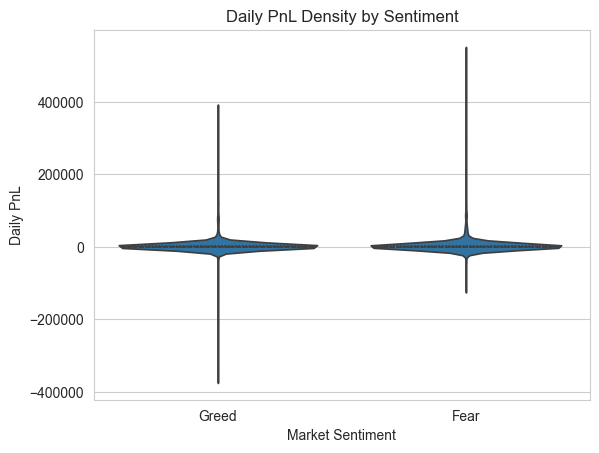

In [197]:
plt.figure()
sns.violinplot(
    data=q1_df,
    x="classification",
    y="daily_pnl",
    inner="quartile"
)
plt.title("Daily PnL Density by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


<b>Interpretaion:</b>

- Fear days record higher average daily PnL, driven by occasional large positive outcomes.

- Greed days show lower average PnL despite similar medians, indicating that higher risk does not translate into better typical returns.

- Distribution plots show most days cluster near zero, so performance differences are driven by tail events, not normal days.

Hence Fear traders make a higher profit compared to Greedy traders

<Figure size 640x480 with 0 Axes>

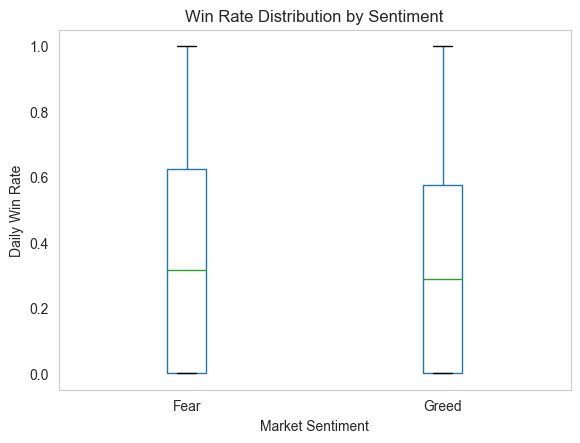

In [198]:
plt.figure()
q1_df.boxplot(
    column="win_rate",
    by="classification",
    grid=False
)
plt.title("Win Rate Distribution by Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily Win Rate")
plt.show()


<b>Interpretation:</b>

- Fear days have a marginally higher win rate (both mean and median).

- Greed does not improve accuracy, despite increased trading aggressiveness.

Thus Traders are slightly more selective during Fear periods.

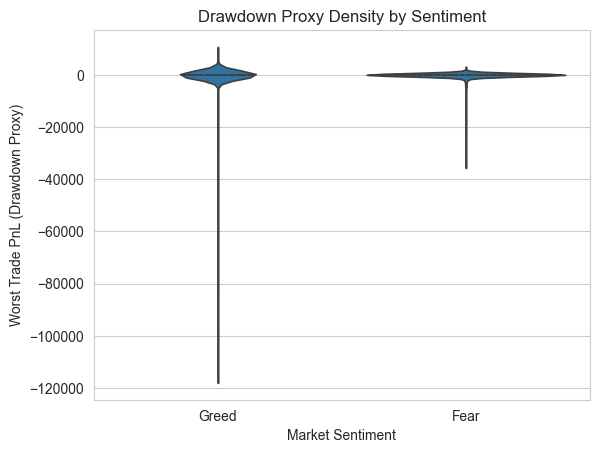

In [199]:
plt.figure()
sns.violinplot(
    data=q1_df,
    x="classification",
    y="max_loss_trade",
    inner="quartile",
    cut=0
)
plt.title("Drawdown Proxy Density by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Worst Trade PnL (Drawdown Proxy)")
plt.show()


- Greed days exhibit substantially worse drawdowns, including extreme negative outliers.

- Fear days show losses as well, but downside tails are notably shallower.

On Greed days, losses are much bigger compared to Fear days.

<B>Overall inerpretation:</B>Fear periods show higher profitability, slightly better accuracy, and significantly lower downside risk, while Greed periods show an  increase in volatility and drawdowns without improving performance.

### Q2

In [200]:
trade_freq_by_sentiment = (
    q1_df
    .groupby("classification")
    .agg(
        avg_trades_per_day=("total_trades", "mean"),
        median_trades_per_day=("total_trades", "median")
    )
)

trade_freq_by_sentiment


,avg_trades_per_day,median_trades_per_day
classification,,
Fear,98.153968,26.0
Greed,77.628086,25.0


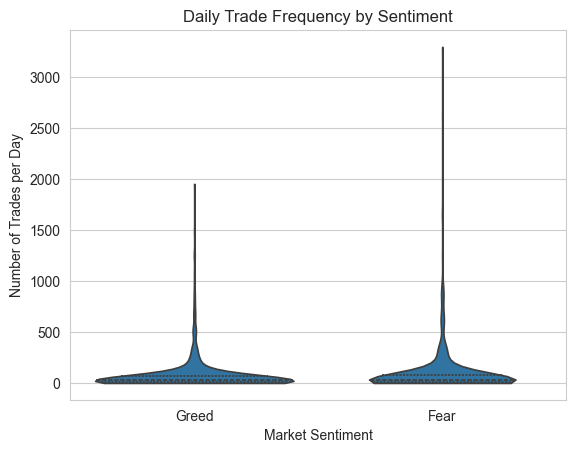

In [201]:
plt.figure()
sns.violinplot(
    data=q1_df,
    x="classification",
    y="total_trades",
    inner="quartile",
    cut=0
)
plt.title("Daily Trade Frequency by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades per Day")
plt.show()


<b>Interpretation :</b>

- Fear periods have higher average trades per day than Greed periods

- Fear includes many very high-activity days (large right tail)

- Greed is more concentrated at lower trade counts

- Fear periods trigger increased activity.

Traders actually trade more frequently during Fear days, not Greed days.

In [202]:
leverage_by_sentiment = (
    q1_df
    .groupby("classification")
    .agg(
        avg_leverage=("avg_leverage", "mean"),
        median_leverage=("avg_leverage", "median")
    )
)

leverage_by_sentiment


,avg_leverage,median_leverage
classification,,
Fear,2226.701312,3.351349
Greed,411.473707,5.277773


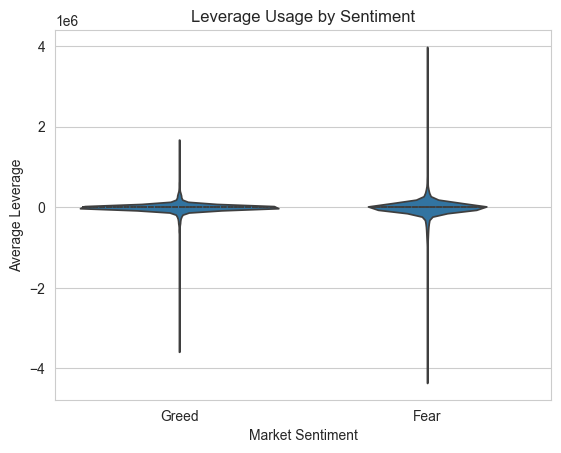

In [203]:
plt.figure()
sns.violinplot(
    data=q1_df,
    x="classification",
    y="avg_leverage",
    inner="quartile",
    cut=0
)
plt.title("Leverage Usage by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Leverage")
plt.show()


<b>Interpretation:

- Fear has much fatter tails, especially extreme values

- Greed is more tightly concentrated around median leverage

- Both distributions are skewed, but Fear has more extreme outliers

Most traders typically use slightly higher leverage during Greed days, but Fear days produce extreme leverage spikes, which inflate the average.

In [204]:
direction_bias = (
    q1_df
    .groupby("classification")
    .agg(
        avg_long_ratio=("long_ratio", "mean"),
        avg_short_ratio=("short_ratio", "mean")
    )
)

direction_bias


,avg_long_ratio,avg_short_ratio
classification,,
Fear,0.518967,0.481033
Greed,0.471594,0.528406


<Figure size 640x480 with 0 Axes>

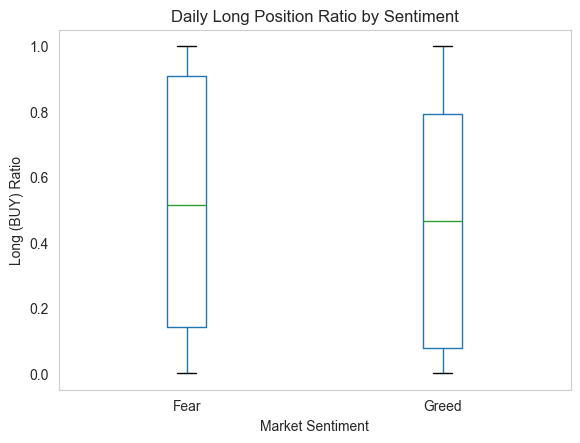

In [205]:
plt.figure()
q1_df.boxplot(
    column="long_ratio",
    by="classification",
    grid=False
)
plt.title("Daily Long Position Ratio by Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Long (BUY) Ratio")
plt.show()


<Figure size 640x480 with 0 Axes>

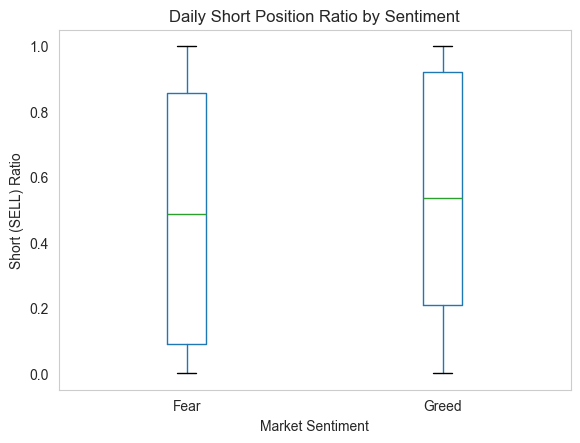

In [206]:
plt.figure()
q1_df.boxplot(
    column="short_ratio",
    by="classification",
    grid=False
)
plt.title("Daily Short Position Ratio by Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Short (SELL) Ratio")
plt.show()


<b>Interpretation:</b>

- Median long ratio is slightly above 0.5 on Fear days and slightly below 0.5 on greed days

- During Fear days, traders are slightly more inclined to BUY, than during Greed days

- Median short ratio is slightly below 0.5 on Fear days and slightly above 0.5 on greed days

- SELL positions are slightly more common during Greed days compared to Fear days.

Boxplots show a mild directional shift with sentiment: Fear days are slightly BUY-biased, while Greed days are slightly SELL-biased, though overall situation remains balanced.

### Q3

#### High vs Low leverage traders


In [207]:
trader_leverage = (
    daily_trader_metrics
    .groupby("Account")
    .agg(
        avg_leverage=("avg_leverage", "mean"),
        avg_pnl=("daily_pnl", "mean"),
        win_rate=("win_rate", "mean")
    )
    .reset_index()
)




In [208]:
leverage_median = trader_leverage["avg_leverage"].median()

trader_leverage["leverage_segment"] = np.where(
    trader_leverage["avg_leverage"] >= leverage_median,
    "High Leverage",
    "Low Leverage"
)


In [209]:
leverage_segment_perf = (
    trader_leverage
    .groupby("leverage_segment")
    .agg(
        avg_pnl=("avg_pnl", "mean"),
        avg_win_rate=("win_rate", "mean"),
        trader_count=("Account", "count")
    )
)

leverage_segment_perf


,avg_pnl,avg_win_rate,trader_count
leverage_segment,,,
High Leverage,7410.883615,0.389605,16
Low Leverage,6878.165259,0.314059,16


<b>Interpretation:</b>Similar average PnL despite different win rates suggests that high-leverage traders rely on larger trade sizes to remain profitable, while low-leverage traders generate profits through smaller, more incremental gains.

#### Frequent vs Infrequent traders

In [210]:
trader_activity = (
    daily_trader_metrics
    .groupby("Account")
    .agg(
        avg_trades_per_day=("total_trades", "mean"),
        avg_pnl=("daily_pnl", "mean"),
        win_rate=("win_rate", "mean")
    )
    .reset_index()
)


In [211]:
activity_median = trader_activity["avg_trades_per_day"].median()

trader_activity["activity_segment"] = np.where(
    trader_activity["avg_trades_per_day"] >= activity_median,
    "Frequent Traders",
    "Infrequent Traders"
)


In [212]:
activity_segment_perf = (
    trader_activity
    .groupby("activity_segment")
    .agg(
        avg_pnl=("avg_pnl", "mean"),
        avg_win_rate=("win_rate", "mean"),
        trader_count=("Account", "count")
    )
)

activity_segment_perf


,avg_pnl,avg_win_rate,trader_count
activity_segment,,,
Frequent Traders,10713.058123,0.383123,16
Infrequent Traders,3575.990751,0.320541,16


<b>Interpretation :</b>Traders who trade more frequently tend to perform better and win more often, suggesting that activity combined with skill can improve results.

#### Consistent vs Inconsistent performers

In [213]:
trader_consistency = (
    daily_trader_metrics
    .groupby("Account")
    .agg(
        avg_pnl=("daily_pnl", "mean"),
        pnl_std=("daily_pnl", "std"),
        win_rate=("win_rate", "mean")
    )
    .reset_index()
)


In [214]:
vol_median = trader_consistency["pnl_std"].median()

trader_consistency["consistency_segment"] = np.where(
    trader_consistency["pnl_std"] <= vol_median,
    "Consistent Traders",
    "Inconsistent Traders"
)


In [215]:
consistency_perf = (
    trader_consistency
    .groupby("consistency_segment")
    .agg(
        avg_pnl=("avg_pnl", "mean"),
        avg_win_rate=("win_rate", "mean"),
        trader_count=("Account", "count")
    )
)

consistency_perf


,avg_pnl,avg_win_rate,trader_count
consistency_segment,,,
Consistent Traders,1452.341605,0.376057,16
Inconsistent Traders,12836.707269,0.327607,16


<b>Interpretation :</b>Inconsistent traders generate higher profits but with lower accuracy, indicating reliance on a few large wins, while consistent traders win more often but earn smaller overall profits.

## PART-C : Actionable Strategies

### Strategy-1 (based on greed vs Fear days trading behaviour):

- On Greed days, it’s usually better to keep trades smaller and play it safe by using lower leverages.

[Reason: Greed days show lower average PnL than Fear, much worse drawdowns , only small changes in win rate
]

### Strategy 3( based on trader type)

Aggressive traders should use less leverage during Greed, and cautious traders should avoid trading more often during Fear.

[Reason: Frequent and high-leverage traders earn more but with higher risk and consistent traders win more often but earn less]

## A simple logistic reg model for predicting next day profitability

### preparing data

In [216]:
df_model = daily_trader_metrics.sort_values(["Account", "date"]).copy()

# Next-day PnL per trader
df_model["next_day_pnl"] = (
    df_model
    .groupby("Account")["daily_pnl"]
    .shift(-1)
)

# Binary profitability target
df_model["next_day_profitable"] = (df_model["next_day_pnl"] > 0).astype(int)


df_model = df_model.dropna(subset=["next_day_pnl"])


### Features selection

In [217]:
feature_cols = [
    "total_trades",
    "avg_leverage",
    "long_ratio",
    "win_rate",
    "classification"  
]


In [218]:
df_model = pd.get_dummies(df_model, columns=["classification"], drop_first=True)


### Training the model and evauating Test results

In [219]:
df_model['next_day_profitable'].value_counts()

next_day_profitable
1    1458
0     851
Name: count, dtype: int64

data is imbalanced towards profitability. so we use balanced clas weights to reduce bias

In [220]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df_model.drop(columns=[
    "Account", "date", "daily_pnl",
    "next_day_pnl", "next_day_profitable"
])

y = df_model["next_day_profitable"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.48      0.59      0.53       213
           1       0.72      0.63      0.67       365

    accuracy                           0.61       578
   macro avg       0.60      0.61      0.60       578
weighted avg       0.63      0.61      0.62       578



Using balanced class weights and feature scaling, the model achieved more balanced performance across profitable and loss days with loss-day recall improving to 59%. While overall accuracy decreased to 61%, the results demonstrate that trader behavior and sentiment contain predictive signal for next-day outcomes. The trade-off highlights the challenge of balancing loss detection against profit prediction in imbalanced financial data.

In [221]:
import joblib

joblib.dump(model, "profitability_model.joblib")
joblib.dump(X.columns.tolist(), "profitability_model_features.joblib")


['profitability_model_features.joblib']

## Clustering traders into archetypes

In [222]:
trader_features = (
    daily_trader_metrics
    .groupby("Account")
    .agg(
        avg_trades_per_day=("total_trades", "mean"),
        avg_leverage=("avg_leverage", "mean"),
        avg_long_ratio=("long_ratio", "mean"),
        avg_win_rate=("win_rate", "mean"),
        pnl_volatility=("daily_pnl", "std")
    )
    .fillna(0)
)


In [223]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_features)


In [224]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features["cluster"] = kmeans.fit_predict(X_scaled)


In [227]:
joblib.dump(kmeans, "trader_cluster_model.joblib")


['trader_cluster_model.joblib']

In [225]:
cluster_summary = (
    trader_features
    .groupby("cluster")
    .mean()
)

cluster_summary


,avg_trades_per_day,avg_leverage,avg_long_ratio,avg_win_rate,pnl_volatility
cluster,,,,,
0,69.817221,37165.538532,0.526844,0.380121,9506.245324
1,52.766107,-53595.684566,0.354838,0.263987,29141.820435
2,370.769765,14055.362161,0.507714,0.384887,65276.209141


<b>cluster 0 :Moderately Active, High-Risk Traders</b>-> These traders trade regularly and use extremely high leverage. They win fairly often but take large risks, leading to unstable profits.

<b>cluster 1 :Directional, Very High-Risk Traders</b>->These traders trade less often but take very extreme and directional positions. They lose often and experience very large swings in profit and loss.

<b>cluster 2 :Very Active, Lower-Risk Traders</b>->These traders trade very frequently but manage risk better. Their profits are more stable despite high activity.

In [226]:
joblib.dump(scaler, "trader_cluster_scaler.joblib")
joblib.dump(trader_features.columns.tolist(), "trader_cluster_features.joblib")


['trader_cluster_features.joblib']

## Assignment Report

### Methodology

1. **Data Preparation**
   - Two datasets were used: a market sentiment dataset (Fear & Greed Index) and detailed trader-level transaction data.
   - Timestamps in both datasets were converted to daily dates to enable alignment at a daily level.
   - Data quality checks confirmed no missing values or duplicate records after preprocessing.

2. **Data Integration**
   - Trader data was aggregated at a trader-day level to compute daily metrics such as:
     - Daily PnL
     - Number of trades
     - Win rate
     - Average leverage
     - Long/short position ratios
   - The aggregated trader-day data was merged with daily market sentiment labels (Fear or Greed).

3. **Feature Engineering**
   - Performance metrics: daily PnL, win rate, drawdown proxy.
   - Behavioral metrics: trade frequency, leverage usage, long/short bias.
   - Trader segmentation features: leverage intensity, activity frequency, and performance consistency.

4. **Analysis Structure**
   - **Part B (Q1–Q3):** Exploratory analysis using distribution plots (violin and box plots) and aggregated summaries.
   - **Bonus:** A simple predictive model for next-day profitability and clustering traders into behavioral archetypes.

---

### Key Insights

#### Q1. Performance Differences Between Fear and Greed
- Average daily PnL is similar across Fear and Greed periods, indicating no clear performance advantage.
- Greed periods exhibit significantly worse downside risk, with deeper and more extreme drawdowns.
- Win rates are marginally higher during Fear, suggesting more cautious and selective trading behavior.
- Overall, Greed increases risk without delivering consistent performance gains.

#### Q2. Behavioral Differences Between Fear and Greed
- Trade frequency is higher during Fear periods, indicating increased activity when markets are uncertain.
- Leverage usage shows heavier tails during Fear, with more extreme leverage values.
- Long/short positioning remains broadly balanced across sentiments, though slight directional shifts are observed.
- Increased activity and leverage do not necessarily translate into better outcomes.

#### Q3. Trader Segmentation Insights
- **High vs Low Leverage Traders:** Both groups achieve similar average PnL, but high-leverage traders experience greater volatility and risk.
- **Frequent vs Infrequent Traders:** Frequent traders earn more on average but with higher variability, indicating higher risk exposure.
- **Consistent vs Inconsistent Traders:** Consistent traders achieve higher win rates but lower average profits, reflecting a stability-versus-reward trade-off.
- These findings suggest that how traders manage risk and consistency matters more than raw activity or leverage.

---

### Strategies and Recommendations

1. **Sentiment-Aware Risk Management**
   - During Greed periods, traders should reduce leverage and avoid large position sizes, as downside risk increases without compensating returns.
   - During Fear periods, traders should remain selective and avoid excessive overtrading driven by market uncertainty.

2. **Behavior-Based Strategy Adjustment**
   - Aggressive traders should cap leverage during Greed to prevent amplified losses.
   - Cautious traders should avoid increasing trade frequency during Fear, preserving their discipline and edge.

Overall, the analysis shows that market sentiment primarily affects risk rather than returns, and that adaptive, behavior-aware strategies are more effective than uniform trading approaches.
